In [ ]:
#% cd drive/MyDrive/Colab\ Notebooks
!pip install pydicom
!pip install  chart_studio
#!pip install skimage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached chart_studio-1.1.0-py3-none-any.whl (64 kB)
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=de50c94e6dcbc58264835af53c944277ec28b481e9fa0a9e11eedae93e7191ba
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import operator
import pydicom as dicom
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from PIL import Image 
import glob
import math
from ipywidgets.widgets import * 
from plotly.graph_objs import *
import chart_studio
from ipywidgets.widgets import * 
import ipywidgets as widgets
from google.colab import drive
from numpy.random import default_rng
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
class FuzzySegmentation():

    def __init__(self, pathToImagesFolder):
        self.pathToImageFolder = pathToImagesFolder
        self.imagesNamesList = []
        self.getImagesList()
        self.numberOfStackImages = len(self.imagesNamesList)
        self.imageStack = []
        self.getImageStack()
        self.imageHUStack = []
        self.getImageHUStack()

    def getImagesList(self):
        patient_folder = self.pathToImageFolder
        self.imagesNamesList = glob.glob(patient_folder + "/*.dcm")
        self.imagesNamesList.sort(key= lambda x: dicom.dcmread(x).InstanceNumber)
        
    def PixelInROI(self):
        image_path = self.imagesNamesList[math.floor(self.numberOfStackImages/2)]
        dicomSource = dicom.dcmread(image_path)
        plt.imshow(dicomSource.pixel_array)

    def SlicePlot(self, sliceNumber):
        image_path = self.imagesNamesList[sliceNumber]
        dicomSource = dicom.dcmread(image_path)
        plt.imshow(dicomSource.pixel_array)
        
    def getImageStack(self):

        for imageName in self.imagesNamesList:
            image_path = imageName
            dicomSource = dicom.dcmread(image_path)
            self.imageStack.append(dicomSource.pixel_array.astype(float))

    def getImageHUStack(self):
        scans = self.load_scan()
        matrix = []

        for i in range(self.numberOfStackImages):
            ds = dicom.dcmread(self.imagesNamesList[i])    #<class 'pydicom.dataset.FileDataset'>
            matrix.append(ds.pixel_array)                 #list
        
        image = np.stack(matrix)   
        image = image.astype(np.int16)
        # Set outside-of-scan pixels to 0
        # The intercept is usually -1024, so air is approximately 0
        image[image == -2000] = 0
        
        # Convert to Hounsfield units (HU)
        intercept = scans[0].RescaleIntercept
        slope = scans[0].RescaleSlope
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)
        
        self.imageHUStack = np.array(image, dtype=np.int16)

    def load_scan(self):
        slices = [dicom.read_file(path) for path in self.imagesNamesList]   
        try:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except:
            print("except")
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
        for s in slices:
            s.SliceThickness = slice_thickness
            
        return slices
        
    def plot_3d(self, threshold=0): 
        image = self.imageStack
        image = np.array(image)
        print("shape image: ", np.shape(image))
        p = image.transpose(2,1,0)
        print("shape p: ", np.shape(p))
        verts, faces, normals, values = measure.marching_cubes(p, threshold)
        fig = plt.figure(figsize=(30, 30))
        ax = fig.add_subplot(111, projection='3d')
        mesh = Poly3DCollection(verts[faces], alpha=0.1)
        #face_color = [0.5, 0.5, 1]
        #mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)      #plotar superfície
        ax.set_xlim(0, p.shape[0])
        ax.set_ylim(0, p.shape[1])
        ax.set_zlim(0, p.shape[2])

        plt.show()

    def plot_3d_iterative(self):
        plt.figure(1)
        interact(self.dicom_animation, x=(0, len(self.imageHUStack)-1))

    def dicom_animation(self, x):
        plt.imshow(self.imageHUStack[x], cmap = plt.cm.gray)
        return x

    def segmentation(self, x_objective, y_objective, slice_objective, number_of_segments, m = 2, number_of_trials = 10000, epsolon_min = 0.01):
        img = self.imageStack[slice_objective]
        img = img[150:320,200:320].copy() 
        nx = len(img)
        ny = len(img[0])
        N = nx*ny
        vector_array = self.get_vector_array(img)
        max_intensity = max(vector_array)
        v = self.get_random_v(max_intensity, number_of_segments, nx, ny)
        print("O vetor v: ")
        print(v)
        v_before = v_next = np.zeros((number_of_segments,3), dtype=np.float64)
        trial = 0
        epsolon = self.calculate_epsolon(v, v_before, number_of_segments)

        while trial < number_of_trials and epsolon > epsolon_min:
          U = self.get_fuzzy_matrix(v, vector_array, N, number_of_segments, m, nx, ny)
          v_next, removable_segments = self.get_new_v(U, vector_array, number_of_segments, N, m, ny)
          epsolon = self.calculate_epsolon(v_next, v, number_of_segments)
          trial += 1

          for i in removable_segments:
            number_of_segments -= 1
            U.pop(i)
            v_next.pop(i)

          v = v_next
          print("O vetor v: ")
          print(v)

        mask = np.zeros((nx,ny), dtype=np.float64)
        j = 0  

        for x in range(nx):

          for y in range(ny):

            position = 0
            max_uij = 0

            for i in range(number_of_segments):
              if U[i][j] > max_uij:
                max_uij = U[i][j]
                position = i
            
            mask[x][y] = position
            j += 1

        return mask, U
      
    def get_vector_array(self, img):
        nx = len(img)
        ny = len(img[0])
        N = nx*ny
        vector_array = [0]*N
        j = 0

        for x in range(nx):

          for y in range(ny):

            vector_array[j] = img[x][y]
            j += 1

        return vector_array

    def get_random_v(self, max_intensity, number_of_segments, nx, ny):
      rng = default_rng()
      v = np.zeros((number_of_segments,3), dtype=np.float64)

      for i in range(number_of_segments):
        v[i][0] = np.float64(rng.integers(low = 0, high = nx-1, size = 1))
        v[i][1] = np.float64(rng.integers(low = 0, high = ny-1, size = 1))
        v[i][2] = np.float64(rng.integers(low = 0, high = max_intensity, size = 1))

      return v

    def get_fuzzy_matrix(self, v, vector_array, N, number_of_segments, m, nx, ny):
      # U = [[0]*N]
      # U = U*number_of_segments
      U = np.zeros((number_of_segments, N), dtype=np.float64)
      problem_points = []

      for j in range(N):

        problem = False
        divisor = 0

        for c in range(number_of_segments):

          Dcj = self.D(c, j, v, vector_array[j], ny)
          # divisor += pow(1/Dcj, 1/(m-1))
          if Dcj != 0:
            divisor += pow(1/Dcj, 1/(m-1))
          else:
            problem_points.append(i)
            problem = True
            U[c][j] = 1

        if problem:

          for i in problem_points:

            U[i][j] = 1/len(problem_points)

          problem_points.clear()

        else:

          for i in range(number_of_segments):

            u = pow(self.D(i,j, v, vector_array[j], ny), 1/(m-1))*divisor
            U[i][j] = 1/u

      return U

    def D(self, i, j, v, intensity, ny):
      xj = self.transform_to_vector(j, intensity, ny)
      distance = 0
      weights = [1, 1, 5]

      for k in range(3):
        distance += weights[k]*pow(xj[k]-v[i][k],2)

      return distance

    def get_new_v(self, U, vector_array, number_of_segments, N, m, ny):
      removable_segments = []
      v_next = np.zeros((number_of_segments,3), dtype=np.float64)

      for i in range(number_of_segments):

        sum_uij_xj = 0
        sum_uij_yj = 0
        sum_uij_Ij = 0
        sum_uij = 0

        for j in range(N):
          Xj = self.transform_to_vector(j, vector_array[j], ny)
          uij = pow(U[i][j], m)
          sum_uij_xj += uij*Xj[0]
          sum_uij_yj += uij*Xj[1]
          sum_uij_Ij += uij*Xj[2]
          sum_uij += uij

        if sum_uij == 0:
          removable_segments.append(i)
        else:
          v_next[i][0] = sum_uij_xj/sum_uij
          v_next[i][1] = sum_uij_yj/sum_uij
          v_next[i][2] = sum_uij_Ij/sum_uij

      return v_next, removable_segments
          
    def transform_to_vector(self, j, intensity, ny):
      l = math.floor(j/ny)
      c = j-l*ny
      return [l, c, intensity]
    
    def calculate_epsolon(self, v1, v2, n):
      epsolon = 0

      for i in range(n):
        epsolon += pow(v1[i][0]-v2[i][0],2)+pow(v1[i][1]-v2[i][1],2)+pow(v1[i][2]-v2[i][2],2)

      return epsolon

In [36]:
# %cd drive/MyDrive/Colab\ Notebooks
fuzzy = FuzzySegmentation(r"MD_CP106")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


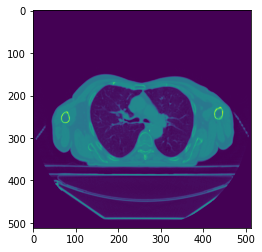

In [ ]:
fuzzy.SlicePlot(35)

In [37]:
fuzzy.plot_3d_iterative()

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=69, description='x', max=138), Output()), _dom_classes=('widget-interact…

In [ ]:
corte = int(input("Entre o corte que contõe a lesão: "))

Entre o corte que contõe a lesão: 35


In [ ]:
posicao_pixel_x = int(input("Entre a posição x do pixel: "))
posicao_pixel_y = int(input("Entre a posição y do pixel: "))

Entre a posição x do pixel: 118
Entre a posição y do pixel: 78


peso I = 1

O vetor v: 
[[ 166.   85.  712.]
 [ 158.   41. 1398.]
 [  37.   44.  976.]
 [ 119.   35.   93.]
 [  81.    4.  460.]]
O vetor v: 
[[  40.93418908   56.75857174  787.64520946]
 [  72.45521568   59.43154652 1507.473566  ]
 [  93.02700905   59.00778077 1022.79686921]
 [  15.87539968   61.79339576   57.17341635]
 [  27.54632581   56.68184143  467.51491862]]
O vetor v: 
[[  34.16565354   59.15676232  831.37057274]
 [  75.67851688   60.16535942 1621.41137194]
 [  97.27749325   58.99543064 1028.70163863]
 [  15.06272994   62.23624177   48.77758762]
 [  26.79461128   57.16606117  467.02757316]]
O vetor v: 
[[  36.06116059   62.22189247  873.91685738]
 [  82.76710084   61.61933207 1720.72837201]
 [  98.3512077    58.89030725 1030.79787789]
 [  14.92574756   62.2849633    46.78425042]
 [  26.66655743   57.12311408  467.69935934]]
O vetor v: 
[[  37.77049321   64.54589581  911.4982371 ]
 [  89.93201185   63.13562526 1802.96766324]
 [  99.63301285   58.79799721 1032.58545956]
 [  14.89549497   62.

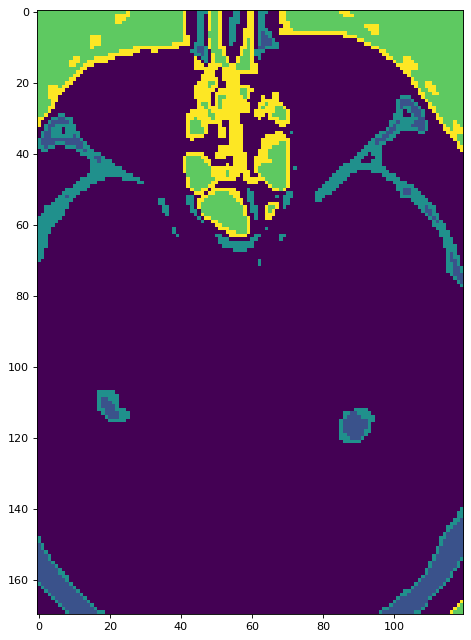

In [38]:
from matplotlib.pyplot import figure

mask, U = fuzzy.segmentation(posicao_pixel_x, posicao_pixel_y, corte, 5, 2, 100000, 0.001)
figure(figsize=(15, 10), dpi=80)
plt.imshow(mask)


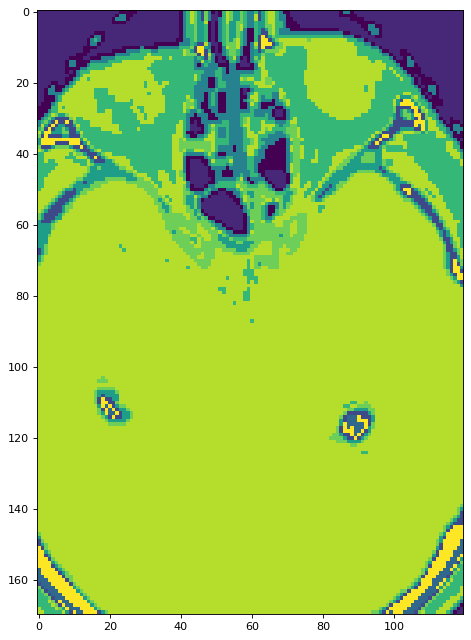

In [ ]:
figure(figsize=(15, 10), dpi=80)
plt.imshow(mask)

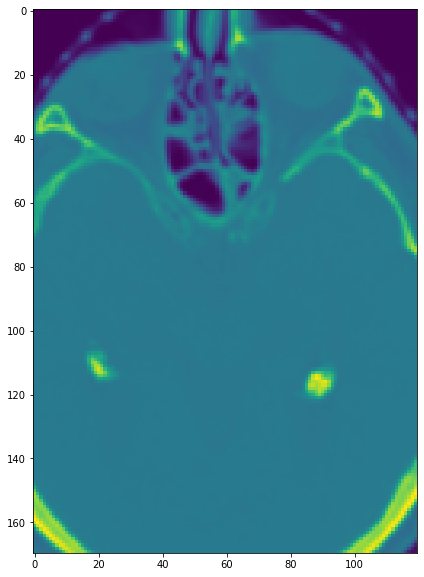

In [ ]:
arr = fuzzy.imageStack[35]
#Need to copy() to meet jpeg2k_encodes C contiguous requirement
arr_crop = arr[150:320,200:320].copy() 
figure(figsize=(15, 10))
plt.imshow(arr_crop)